In [1]:
#import necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import seaborn as sns
import numpy as np

import scanpy as sc

import scipy
scipy.__version__

'1.4.1'

In [25]:
#designate working directory 
#path should contain: matrix.mtx, plate_map.csv, cell_annotate.txt
#for scanpy annotations: barcodes.tsv, genes.tsv
#
#



path='/data/xyzeq/xyzeq/20190319_cell_line.h5ad'

plate_map='/data/xyzeq/xyzeq/plate23_map.csv'



In [6]:
sc.settings.verbosity=3
sc.settings.set_figure_params(dpi=80)
sc.logging.print_versions()
# results_file = './write/results.h5ad'

#sc.settings = True

##load the data
adata=sc.read_h5ad(path)


# ##name the genes
# adata.var_names = [gene.strip() for gene in open(path + 'genes2.tsv', 'r')]


# ##name the cells
# adata.obs_names = [barcode.strip() for barcode in open(path + 'barcodes.tsv', 'r')] 




scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.18.0 scipy==1.4.1 pandas==0.25.3 scikit-learn==0.22 statsmodels==0.10.1 python-igraph==0.7.1


In [7]:
adata.var_names_make_unique()

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


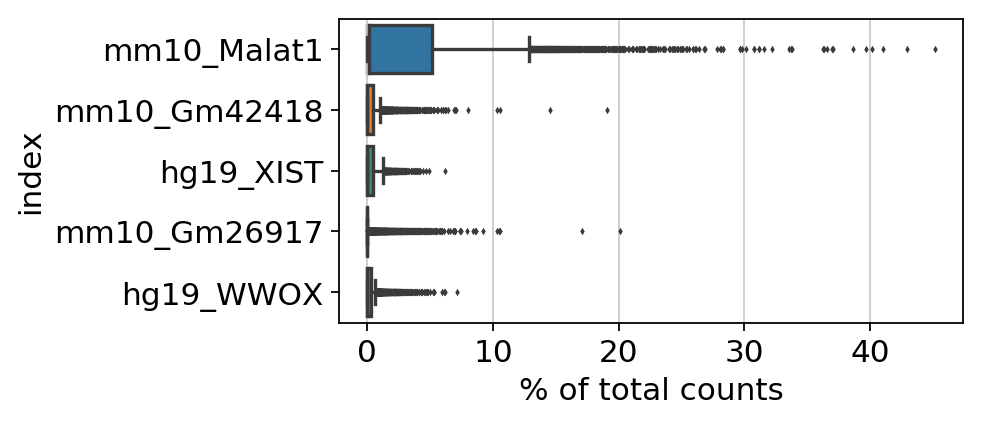

In [8]:
sc.pl.highest_expr_genes(adata, n_top=5) 

In [9]:
adata

AnnData object with n_obs × n_vars = 8276 × 121472 

In [10]:
##post processing filter minimum UMIS and genes
sc.pp.filter_cells(adata, min_counts=200)
sc.pp.filter_cells(adata, min_genes=100)

#sc.pp.filter_cells(adata, max_counts=15000)
#sc.pp.filter_cells(adata, max_genes=2000) 

##post processing filter genes 
sc.pp.filter_genes(adata, min_cells=2)
#sc.pp.filter_genes(adata, max_cells=1000)   

## define mito genes 
mito_genes=[name for name in adata.var_names if name.startswith(('mm10_mt-', 'hg19_mt-', 'mt-'))]


##create new obs anotation to define percent mito for each cell 
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)*100

##create new obs anotation to define UMIs per cell
adata.obs['n_counts'] = adata.X.sum(axis=1)



filtered out 1365 cells that haveless than 200 counts
filtered out 392 cells that haveless than 100 genes expressed
filtered out 89764 genes that are detectedin less than 2 cells


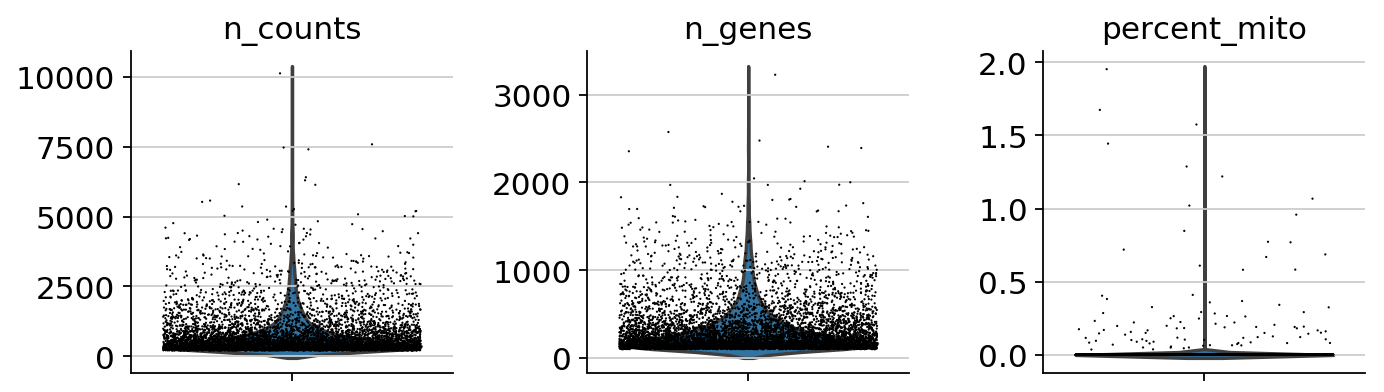

In [11]:
sc.pl.violin(adata, ['n_counts', 'n_genes', 'percent_mito'], jitter=0.4, multi_panel=True)

In [12]:
##filter out outliers

adata = adata[adata.obs['n_genes'] < 15000, :]
adata = adata[adata.obs['n_counts'] < 10000, :]
adata = adata[adata.obs['percent_mito'] < 1, :]


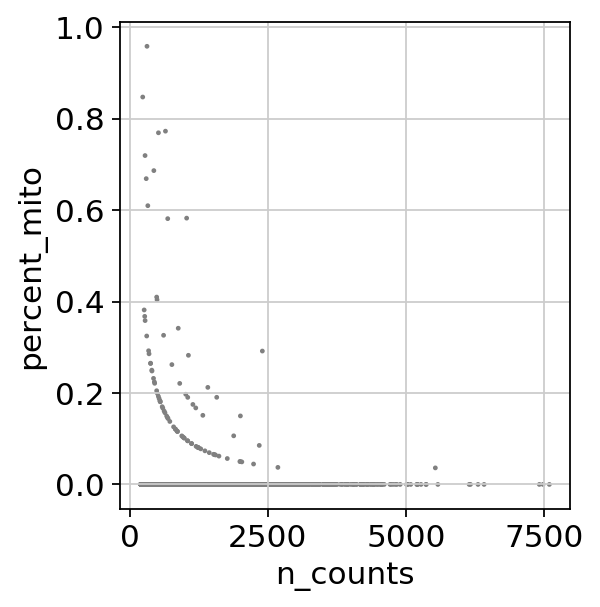

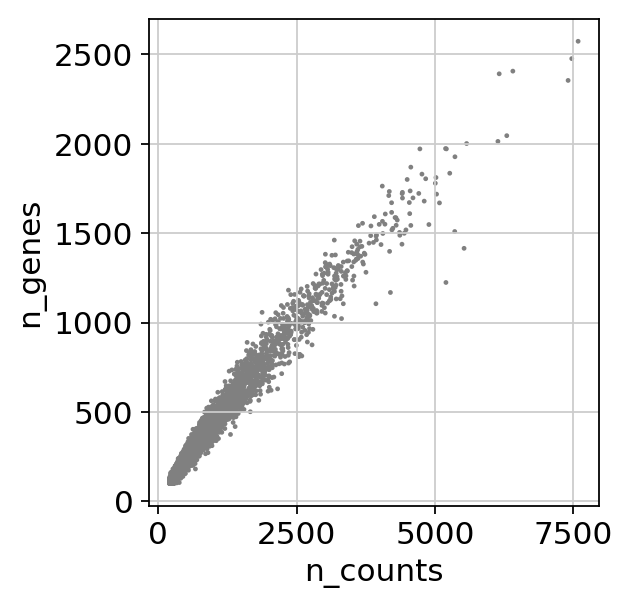

In [13]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')



In [14]:
adata

AnnData object with n_obs × n_vars = 6510 × 31708 
    obs: 'n_counts', 'n_genes', 'percent_mito'
    var: 'n_cells'

In [15]:
#barnyard


mouse_genes=[name for name in adata.var_names if name.startswith('mm10_')]
human_genes=[name for name in adata.var_names if name.startswith('hg19_')]



adata.obs['mouse_counts'] = np.sum(adata[:, mouse_genes].X, axis=1)
adata.obs['human_counts'] = np.sum(adata[:, human_genes].X, axis=1)



In [16]:
# # fig, ax = plt.subplots(figsize=(6, 1))
# fig.subplots_adjust(bottom=0.5)

cmap = mpl.colors.ListedColormap(['royalblue','lightgrey', 'orangered'])


In [96]:
np.seterr(divide = 'ignore') 
adata.obs['ratio'] = np.log10(np.true_divide(adata.obs['mouse_counts'], adata.obs['human_counts']))


def cell_call(counts):
        if counts['ratio'] > 0.83:
                return 'M'
        elif counts['ratio'] < -0.83:
                return 'H'
        else:
                return 'C'

            
            
            
adata.obs['cell_call']=adata.obs.apply(lambda counts: cell_call(counts), axis=1)




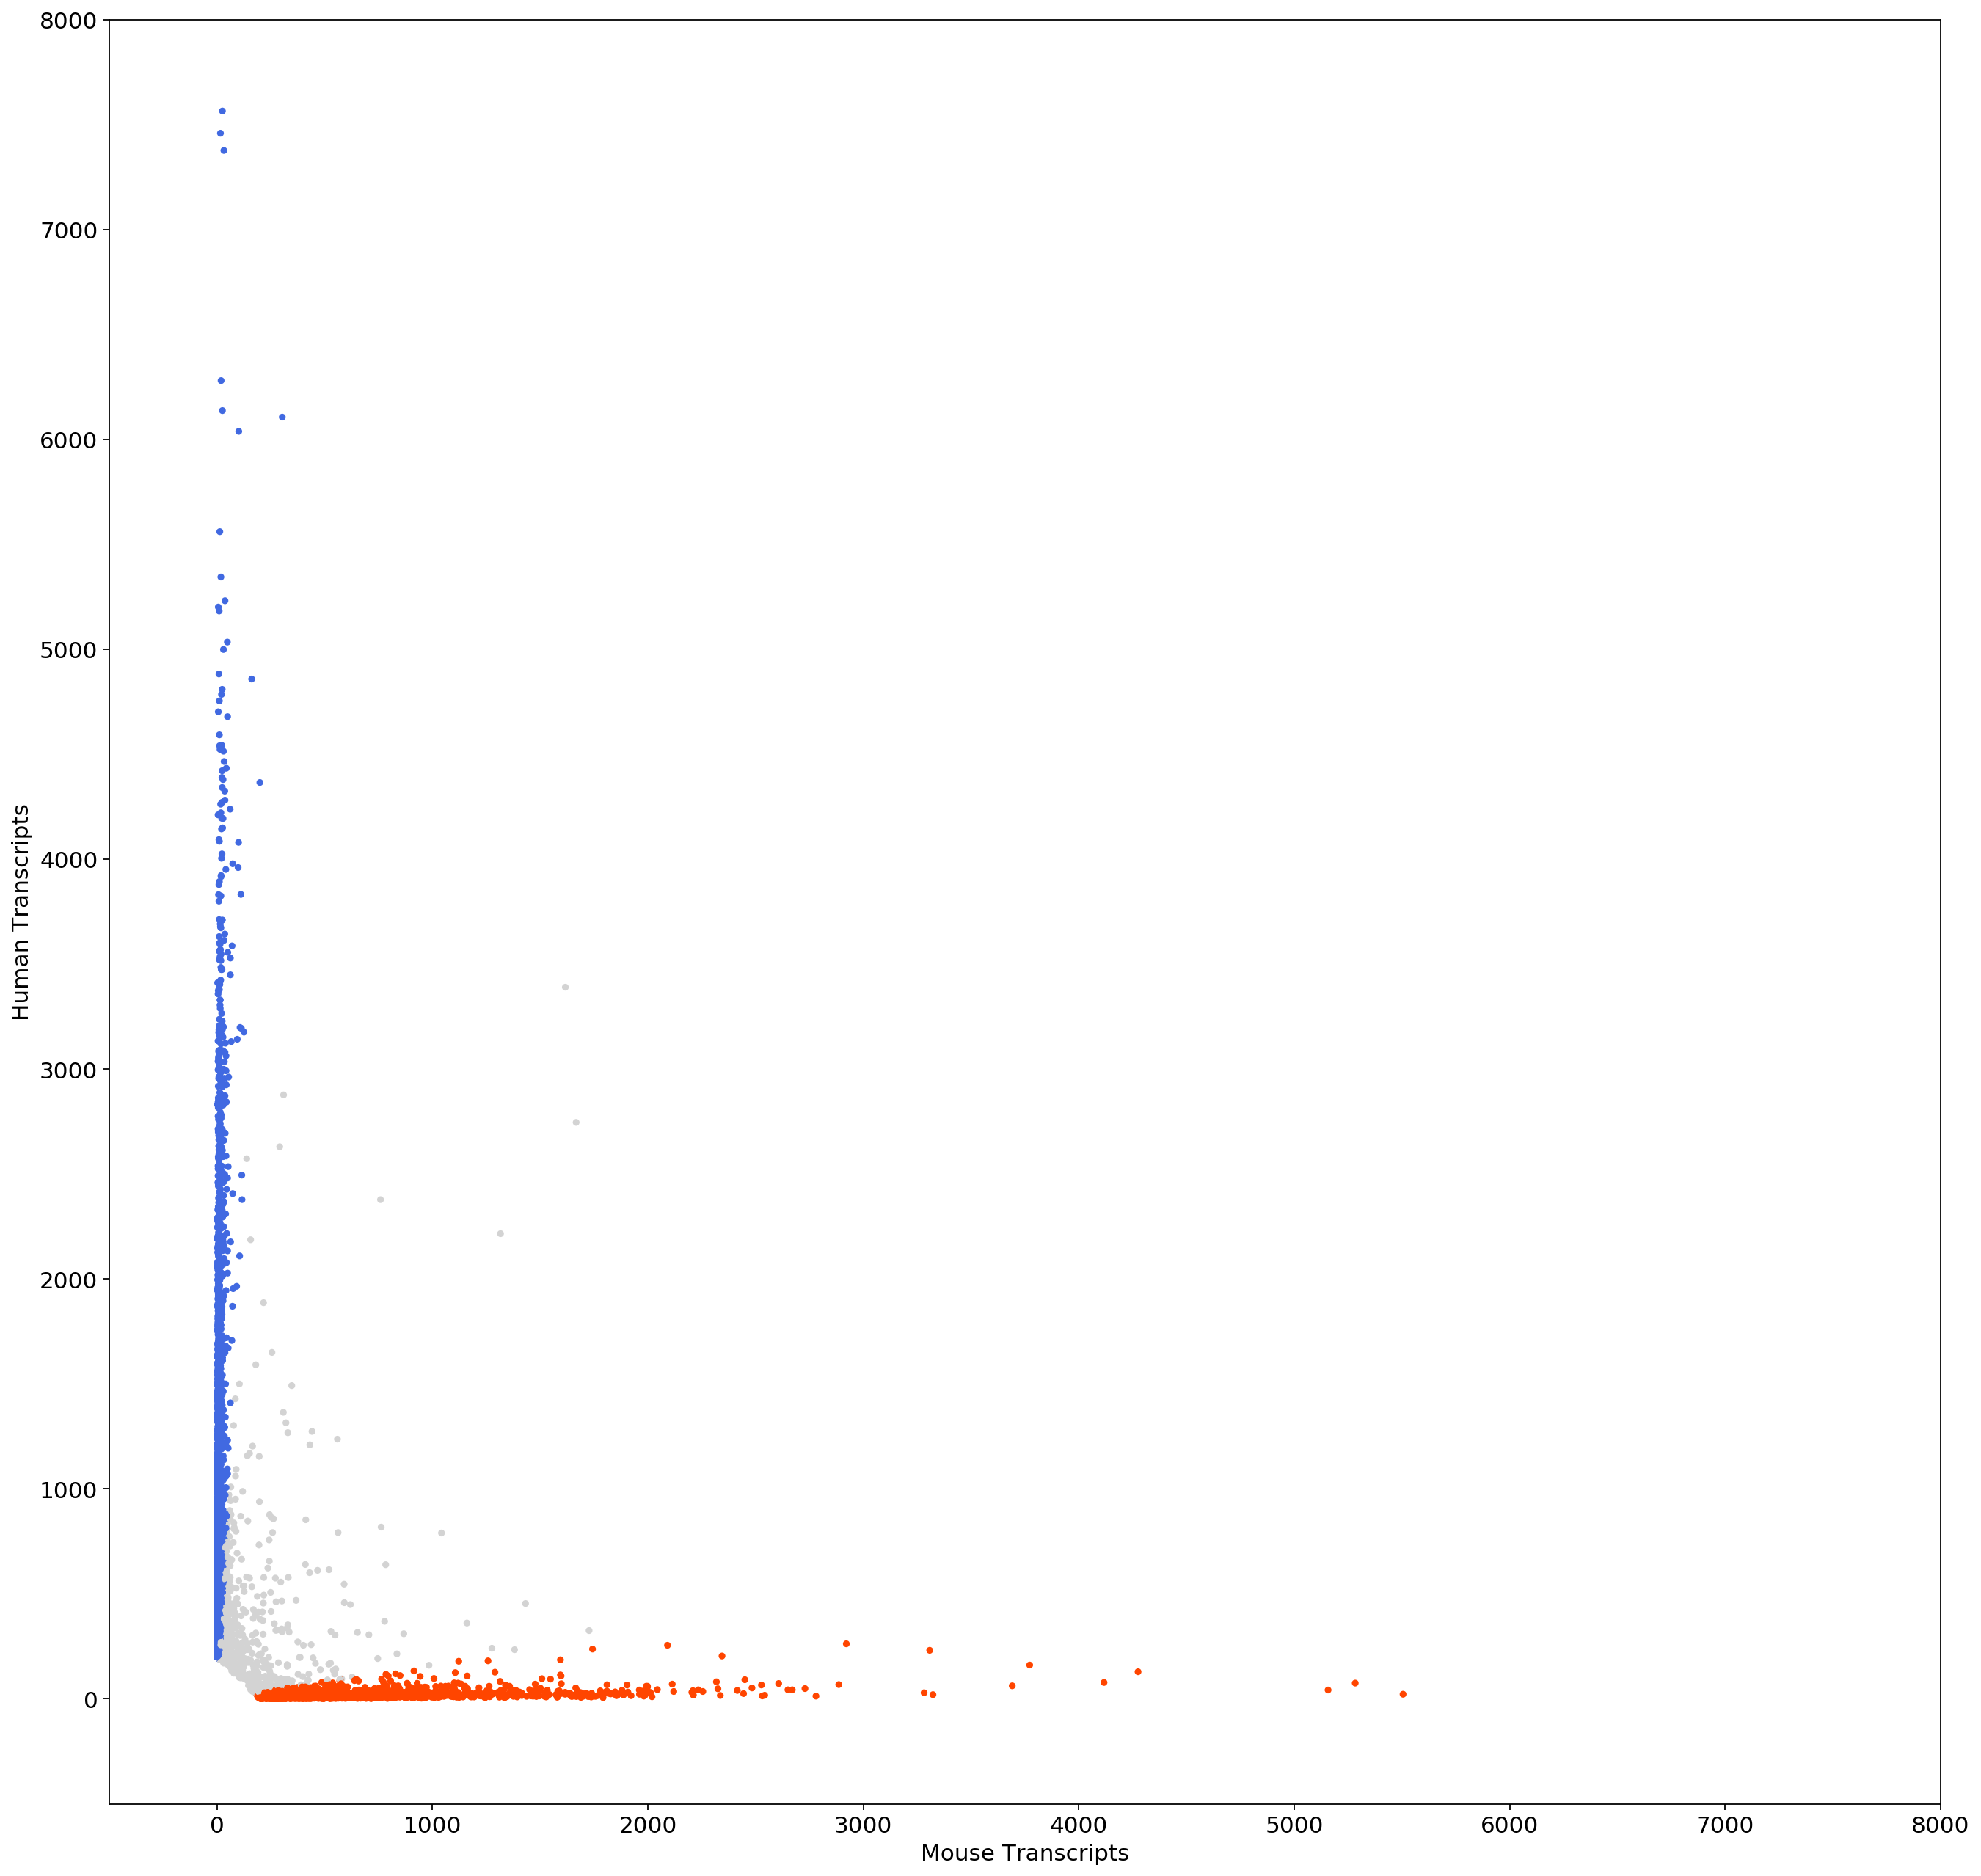

In [97]:
plt.rcParams['figure.figsize'] = [20, 20]

plt.scatter(x=adata.obs['mouse_counts'], 
            y=adata.obs['human_counts'],
            s=10,
            c=adata.obs['ratio'],
           cmap=cmap)


plt.xlabel('Mouse Transcripts')
plt.ylabel('Human Transcripts')
plt.grid(b=False)
plt.xlim(-500,8e3)
plt.ylim(-500,8e3);

#plt.savefig('/Users/derekbogdanoff/Desktop/test.svg', bbox_inches='tight')


In [98]:
adata.obs['cell_call'].value_counts()

H    4377
M    1670
C     463
Name: cell_call, dtype: int64

In [99]:
a = dict(adata.obs['cell_call'].value_counts())

In [100]:
a['C']/(a['H'] + a['M'])

0.07656689267405326

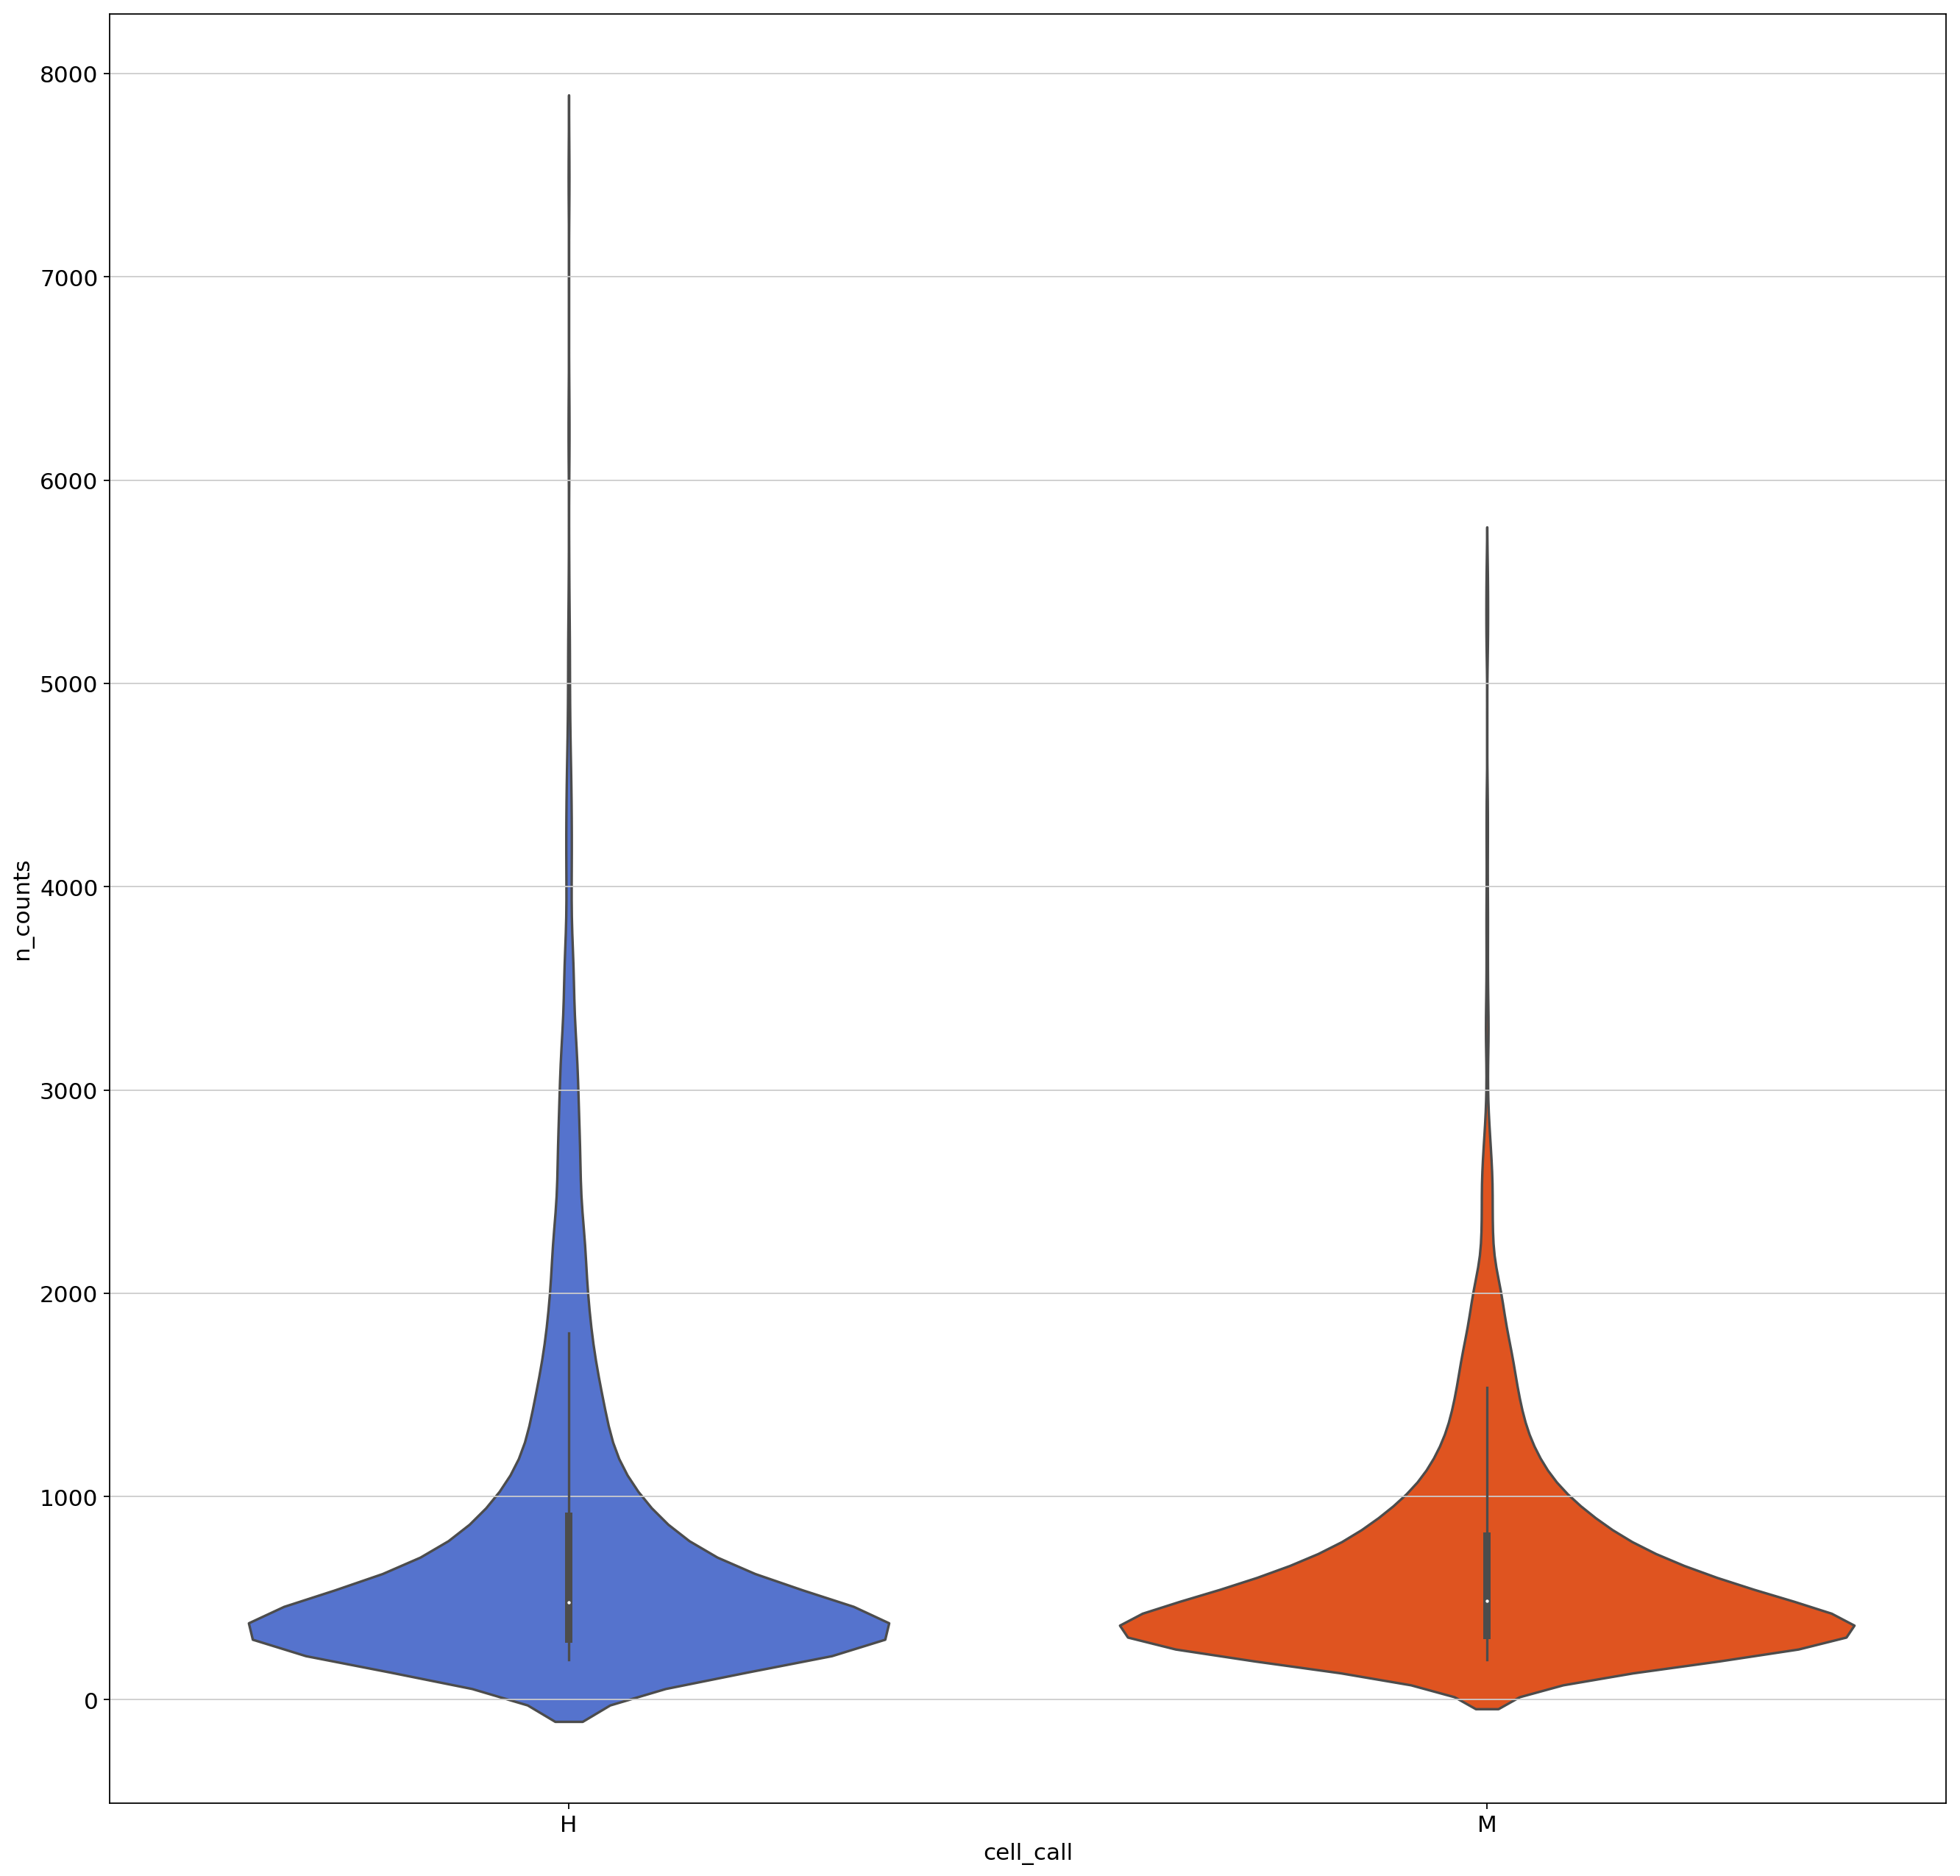

In [20]:
sns.violinplot(data=adata[adata.obs['cell_call'] != 'C'].obs,
               x='cell_call',
               y='n_counts',
               palette=['royalblue', 'orangered']
              )

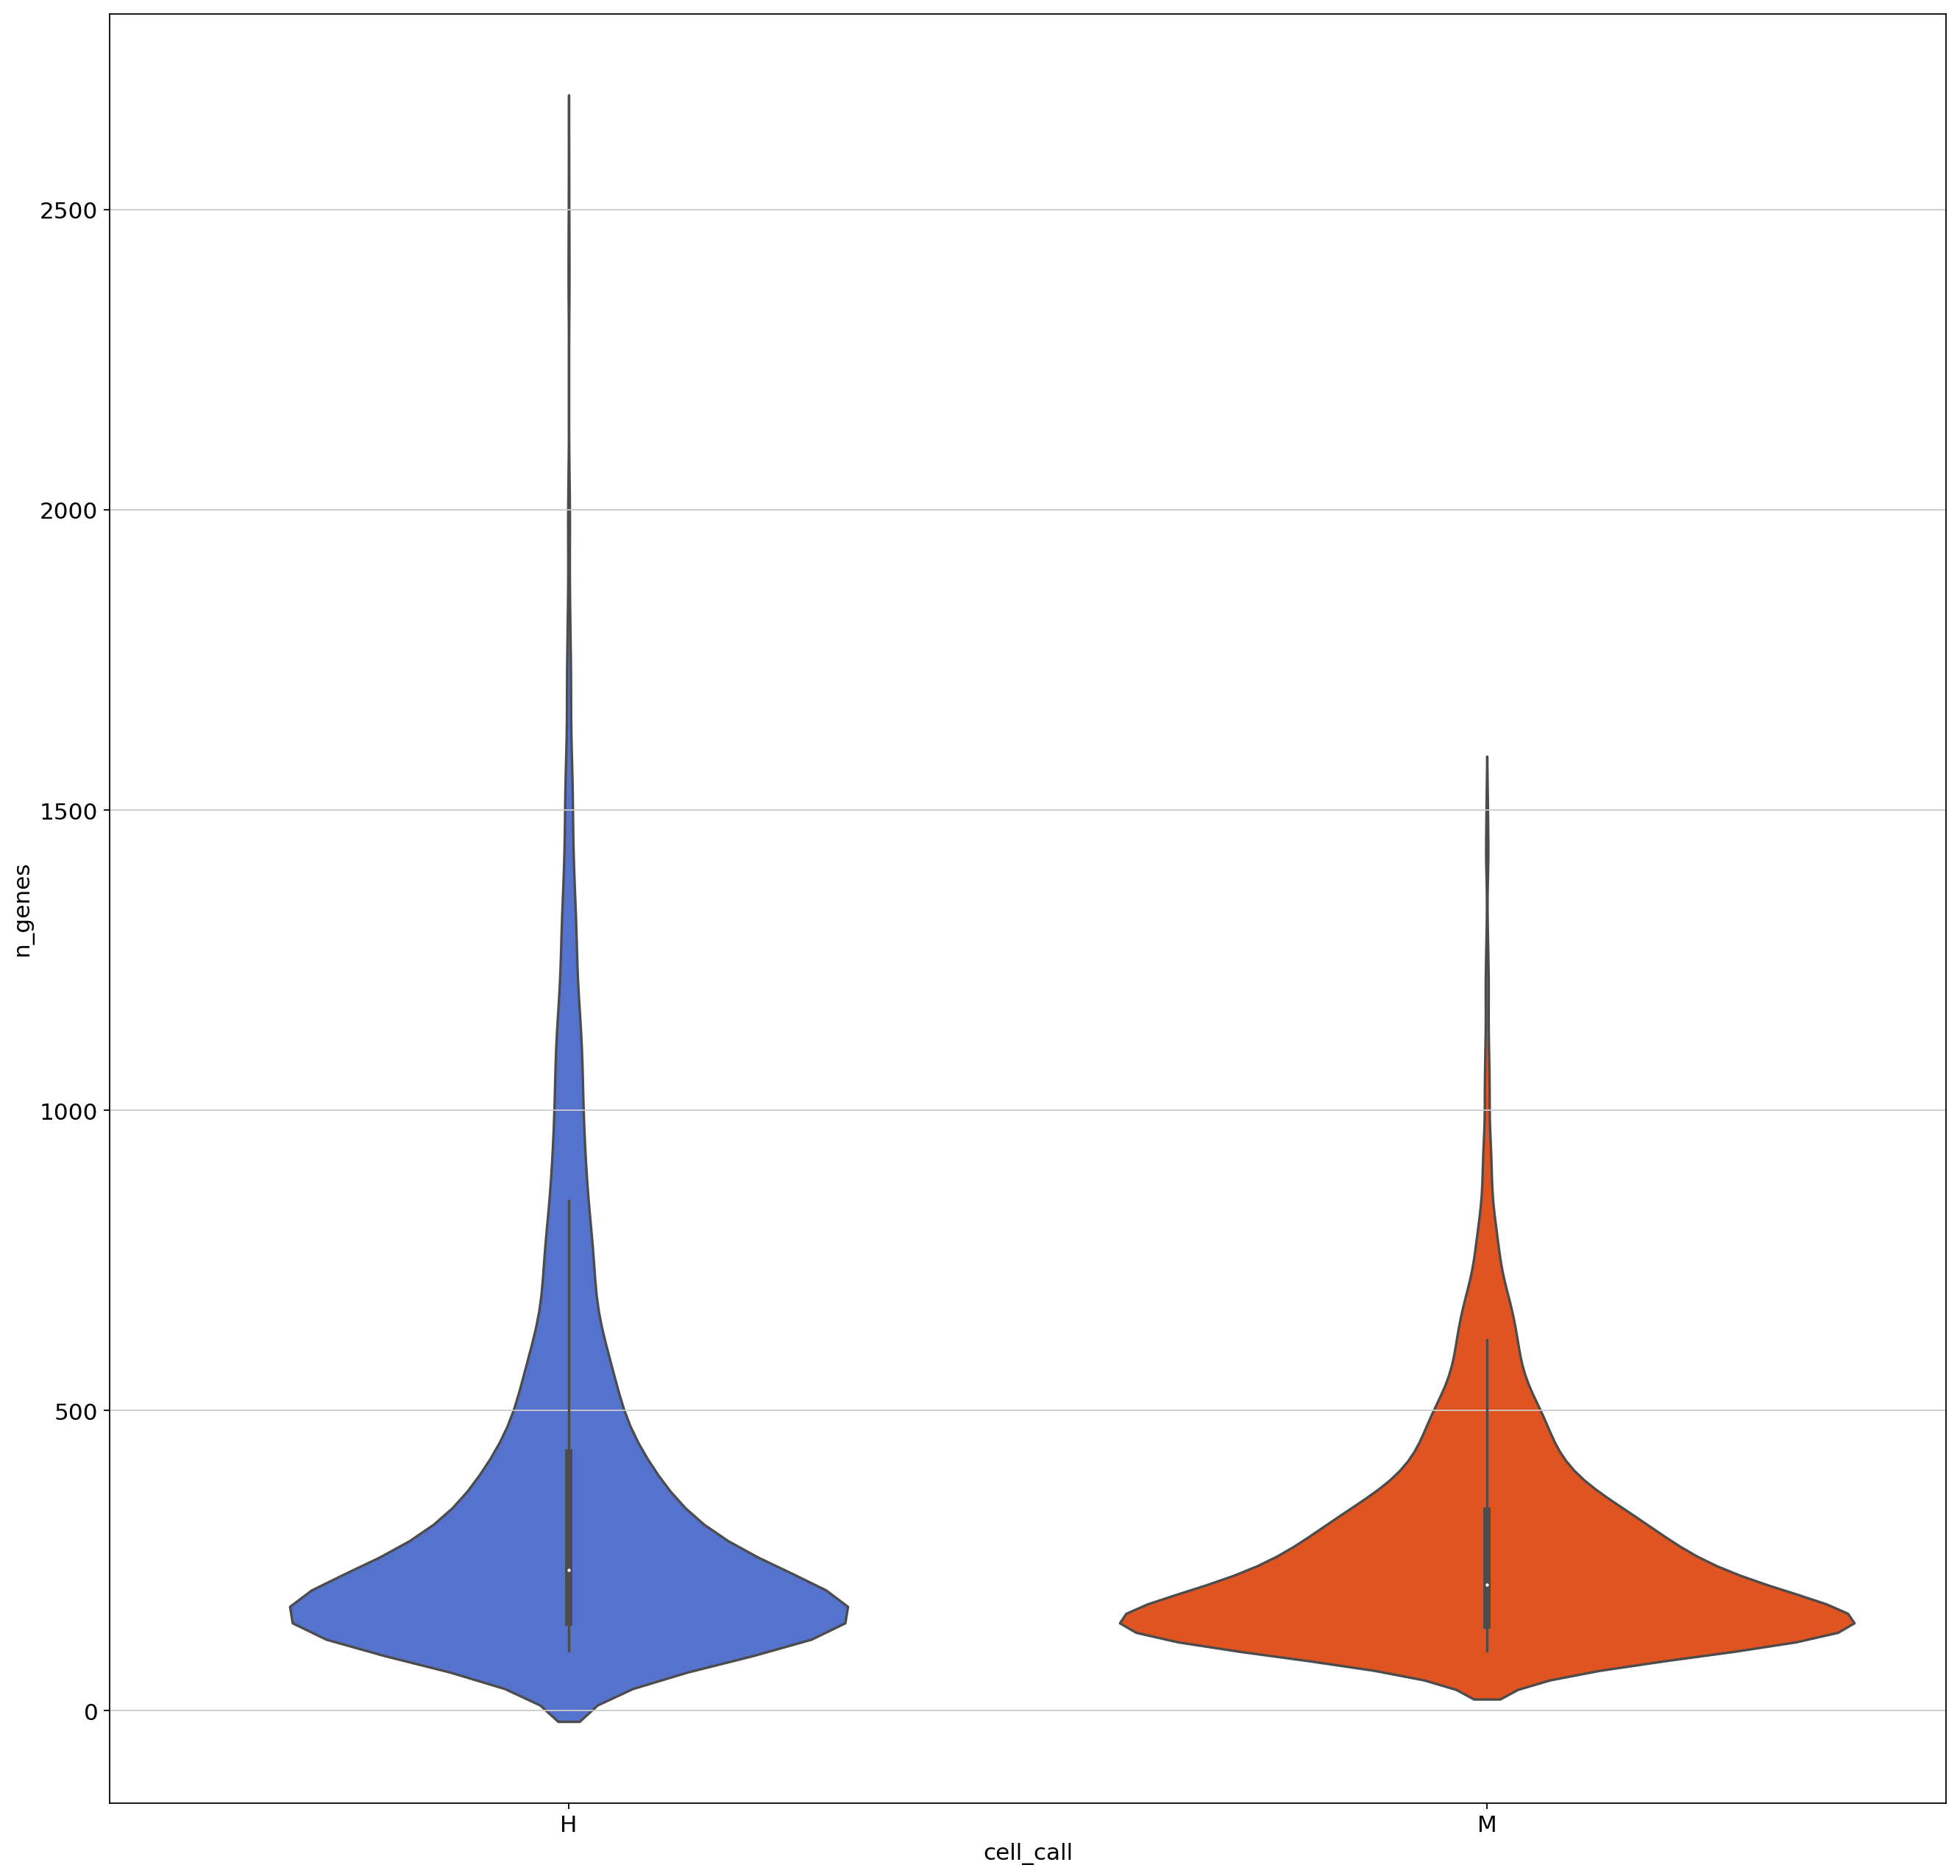

In [21]:
sns.violinplot(data=adata[adata.obs['cell_call'] != 'C'].obs,
               x='cell_call',
               y='n_genes',
               palette=['royalblue', 'orangered']
              )

In [22]:
np.median(adata[adata.obs['cell_call']=='M'].obs.n_genes)

210.0

In [26]:
spatial_map=pd.read_csv(plate_map, header=None, names=['barcode', 'X', 'Y'])





In [27]:
def rand_jitter(arr):
    stdev = .005*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

In [28]:
df=pd.DataFrame(adata.obs.cell_call)

df['barcode']=df.index.str[-16:]

df.cell_call['cell_call']=df.cell_call.astype('category')

df=df.merge(spatial_map,on='barcode',how='right')

df=df.dropna()

In [29]:
list_=[]

for index, row in df.iterrows():
    if row['X'] % 2 != 0:
        row['Y']=row['Y']-0.5
    else:  
        row['Y']=row['Y']
        
    list_.append(row['Y'])
        

In [30]:
df['Y']=list_

In [31]:
df['Y']=df['Y']/2

In [32]:
color_dict={'H':'royalblue', 
            'M':'orangered',
            'C':'lightgrey',
           }

In [33]:
df['color']=df['cell_call'].map(color_dict)

In [34]:
df_bar=df.groupby('X')['cell_call'].value_counts(['']).unstack()

In [35]:
df_bar.columns.name='Cell Species'

In [36]:
df_bar=df_bar[['M','H','C']]

In [37]:
barplot_cmap=mpl.colors.ListedColormap(['red','royalblue','lightgrey'])

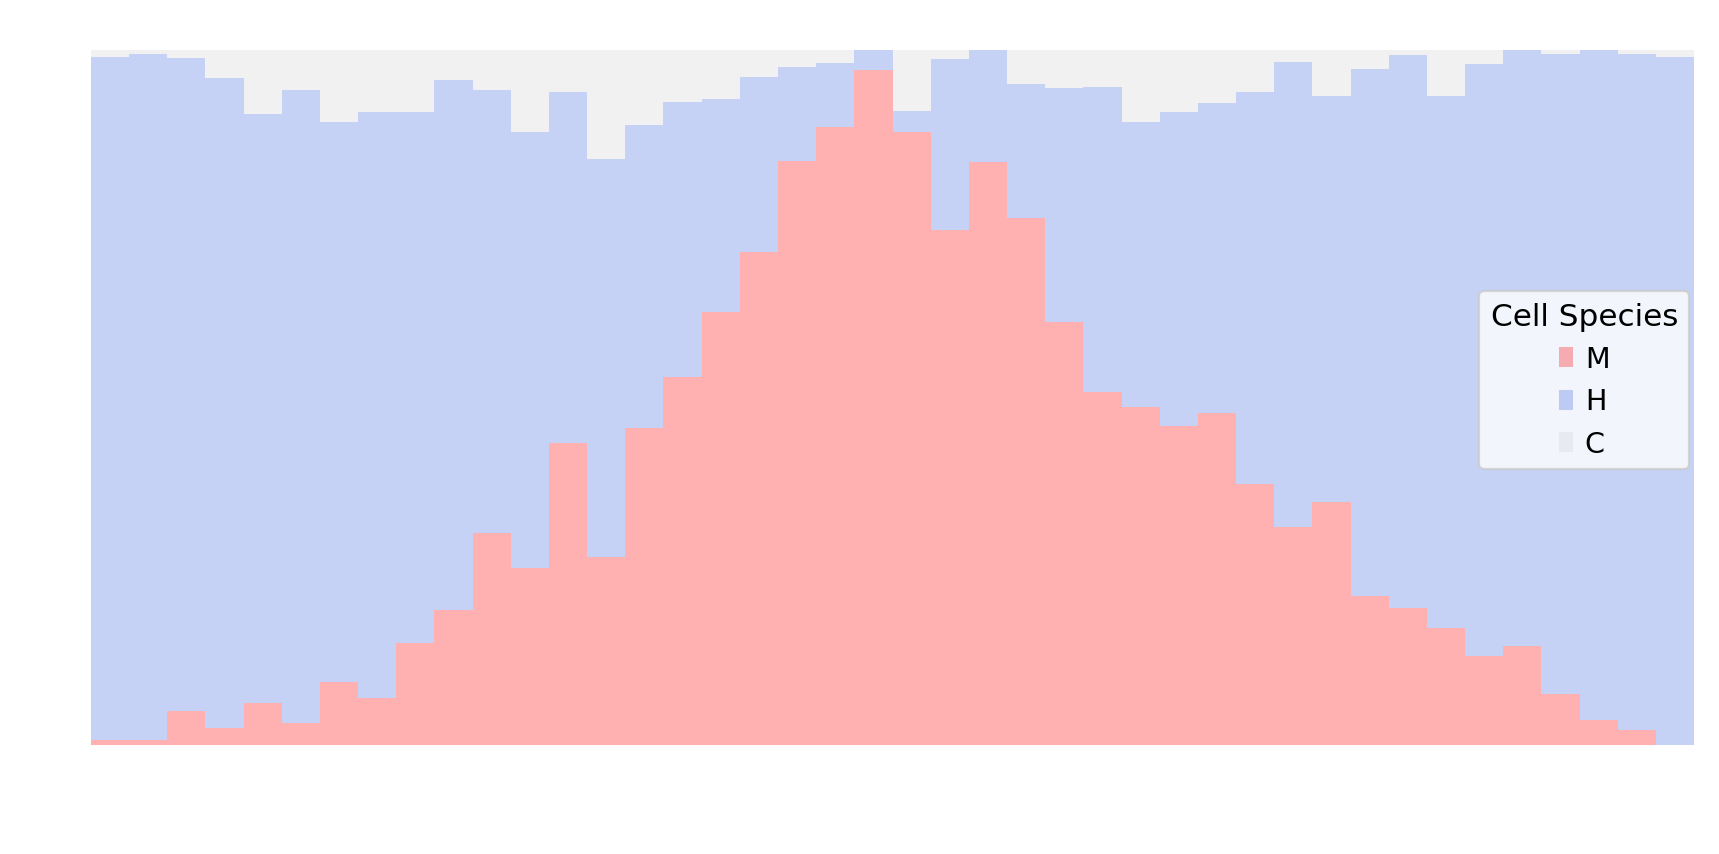

In [38]:
plt.rcParams['figure.figsize'] = [13, 6]

df_bar.plot.bar(stacked=True,
                width=1, 
                cmap=barplot_cmap, 
                ecolor='white',
               alpha=.3)


plt.axis('off')
plt.grid(False)             

In [123]:
df_counts = list()
xs = df['X'].unique()
for x in xs:
    counts = dict(zip(['H','M','C'],[0]*3))
    vs, cs = np.unique(df[df['X'] == x]['cell_call'].values, return_counts=True)
    for v, c in zip(vs, cs):
        counts[v] = c
    df_counts.append([counts['H'], counts['M'], counts['M']/counts['H']])

In [124]:
df_counts = pd.DataFrame(df_counts, index=xs, columns = ['H','M','r_obs'])

In [125]:
df_counts.sort_index(inplace=True)

In [110]:
import itertools as it
from functools import reduce

In [115]:
a = reduce(lambda a, b: a + b,[[i]*2 for i in map(lambda x: np.divide(x,(100-x)),range(0,110,10))])
a = a + a[::-1][2:]

In [127]:
df_counts['r_true'] = a

In [130]:
df_counts = df_counts.replace([np.inf, -np.inf], np.nan).dropna()

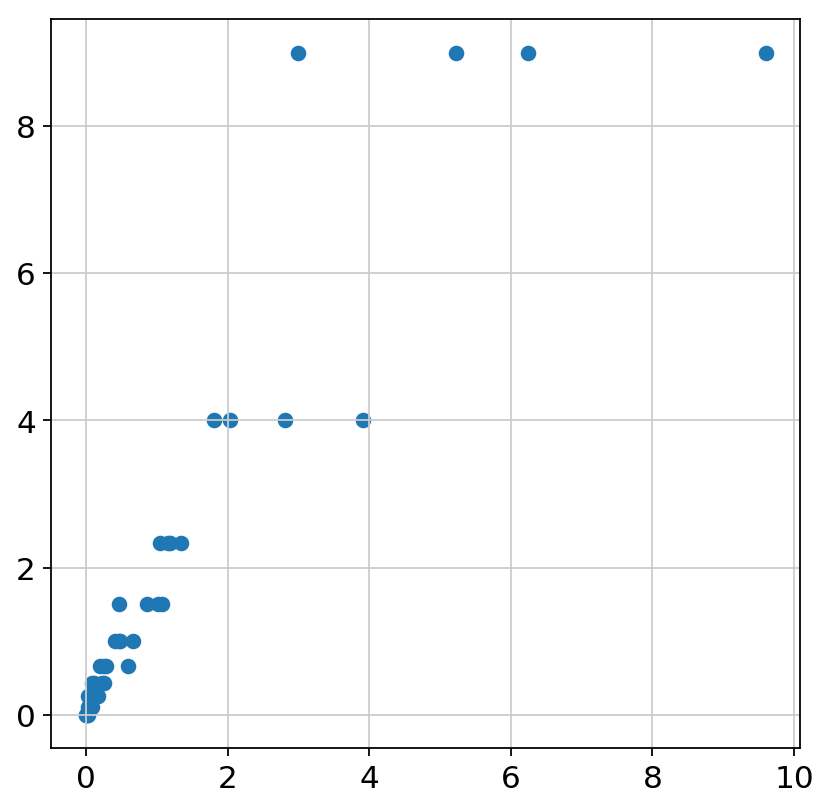

In [133]:
plt.figure(figsize=(6,6))
plt.scatter(df_counts['r_obs'].values, df_counts['r_true'].values);

In [135]:
from scipy.stats import pearsonr

In [136]:
pearsonr(df_counts['r_obs'].values, df_counts['r_true'].values)

(0.909867953648035, 4.263353437193208e-16)

In [179]:
adata = sc.read_h5ad('/data/xyzeq/xyzeq/individual.raw.and.proc.h5ads/fig3.L20C1/adata.6.h5ad')

In [178]:
adata

AnnData object with n_obs × n_vars = 4788 × 789 
    obs: 'n_counts', 'n_genes', 'percent_mito', 'mouse_counts', 'human_counts', 'ratio', 'cell_call', 'leiden', 'celltype'
    var: 'n_cells'
    uns: 'celltype_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [167]:
adata_tsne = sc.read_loom('/data/xyzeq/xyzeq/individual.raw.and.proc.h5ads/20200324/L20C1_mouse_wTSNE.loom')

In [172]:
adata_tsne

AnnData object with n_obs × n_vars = 2867 × 744 
    obs: 'CellType', 'barcode', 'cell_call', 'human_counts', 'leiden', 'log_counts', 'louvain', 'mouse_counts', 'n_counts', 'n_genes', 'percent_contam', 'percent_mito_human', 'percent_mito_mouse', 'ratio'
    var: 'log_cells', 'n_cells'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'

In [169]:
new_names = list()
for i in adata.var_names:
    if i.startswith('hg19_'):
        new_names.append('H_' + i[5:])
    else:
        new_names.append('m_' + i[5:])
adata.var_names = new_names

In [170]:
new_names = list()
for i in adata_tsne.var_names:
    if i.startswith('GRCh38_'):
        new_names.append('H_' + i[7:])
    else:
        new_names.append('m_' + i[7:])
adata_tsne.var_names = new_names

In [171]:
len(np.intersect1d(adata.var_names.values, adata_tsne.var_names.values))

710

In [181]:
sc.read_h5ad('/data/xyzeq/xyzeq/individual.raw.and.proc.h5ads/fig3.L20C1/new.adata.6.h5ad')

AnnData object with n_obs × n_vars = 4788 × 54515 
    obs: 'CellType', 'barcode', 'cell_call', 'human_counts', 'leiden', 'log_counts', 'mouse_counts', 'n_counts', 'n_genes', 'percent_contam', 'percent_mito_human', 'percent_mito_mouse', 'prox_1', 'prox_2', 'ratio'
    var: 'log_cells', 'n_cells'
    obsm: 'X_pca', 'X_tsne', 'X_umap'

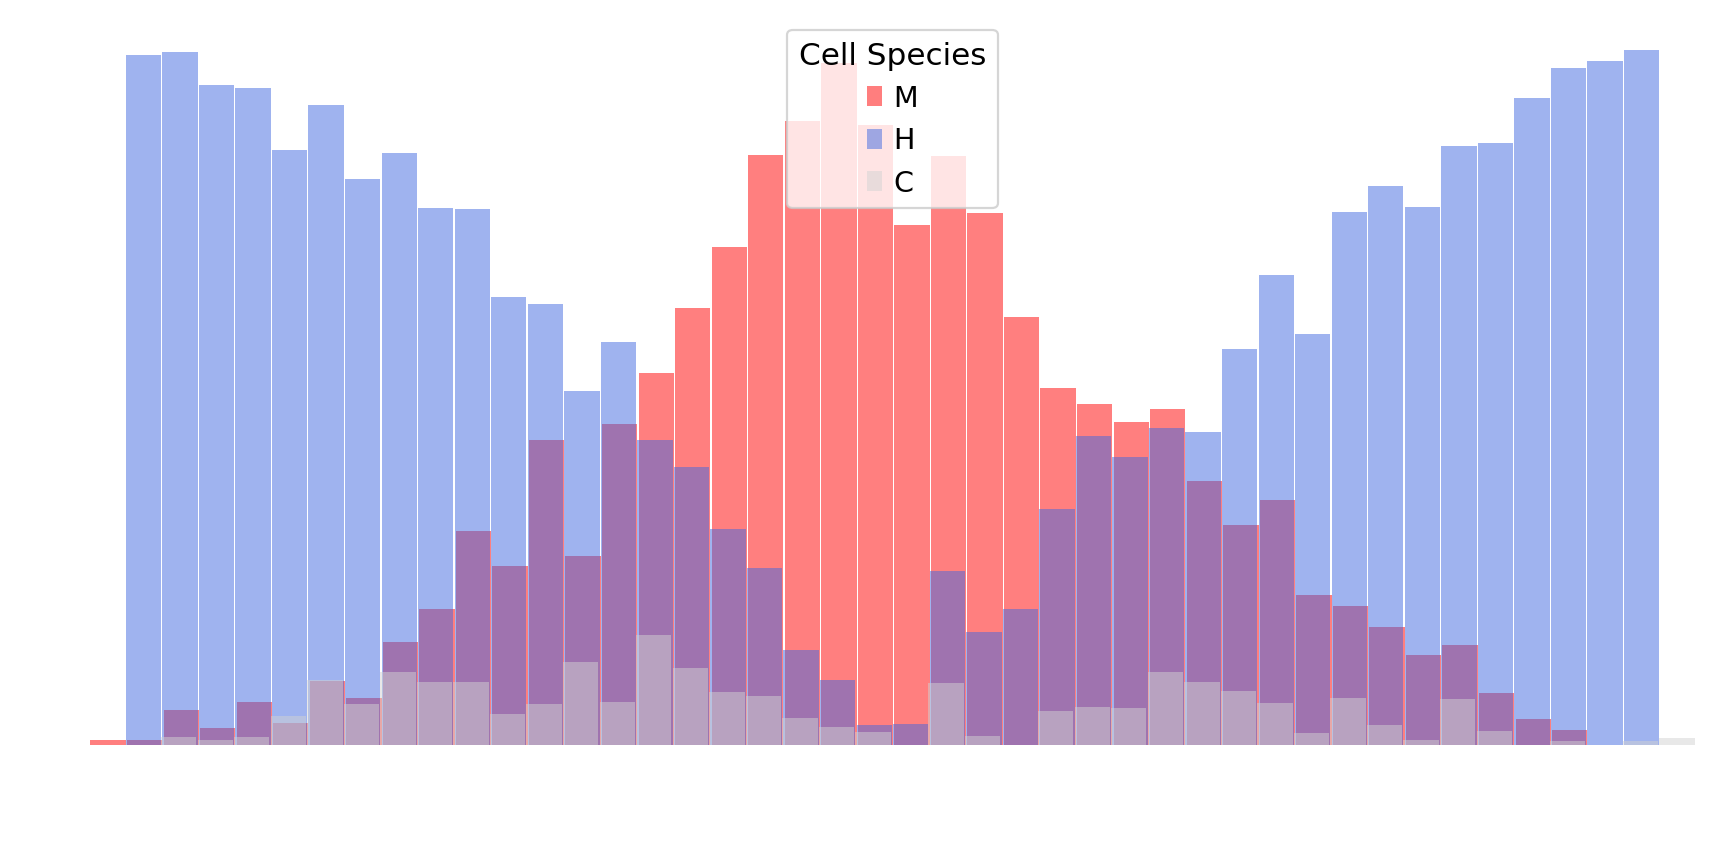

In [34]:
plt.rcParams['figure.figsize'] = [13, 6]

df_bar.plot.bar(stacked=False,
                width=2.9, 
                cmap=barplot_cmap, 
                ecolor='white',
                alpha=.5
               )


plt.axis('off')
plt.grid(False)      

In [35]:
df['counts']=adata.obs['n_counts'].reset_index()['n_counts']

In [36]:
df['log counts']=np.log10(df['counts'])

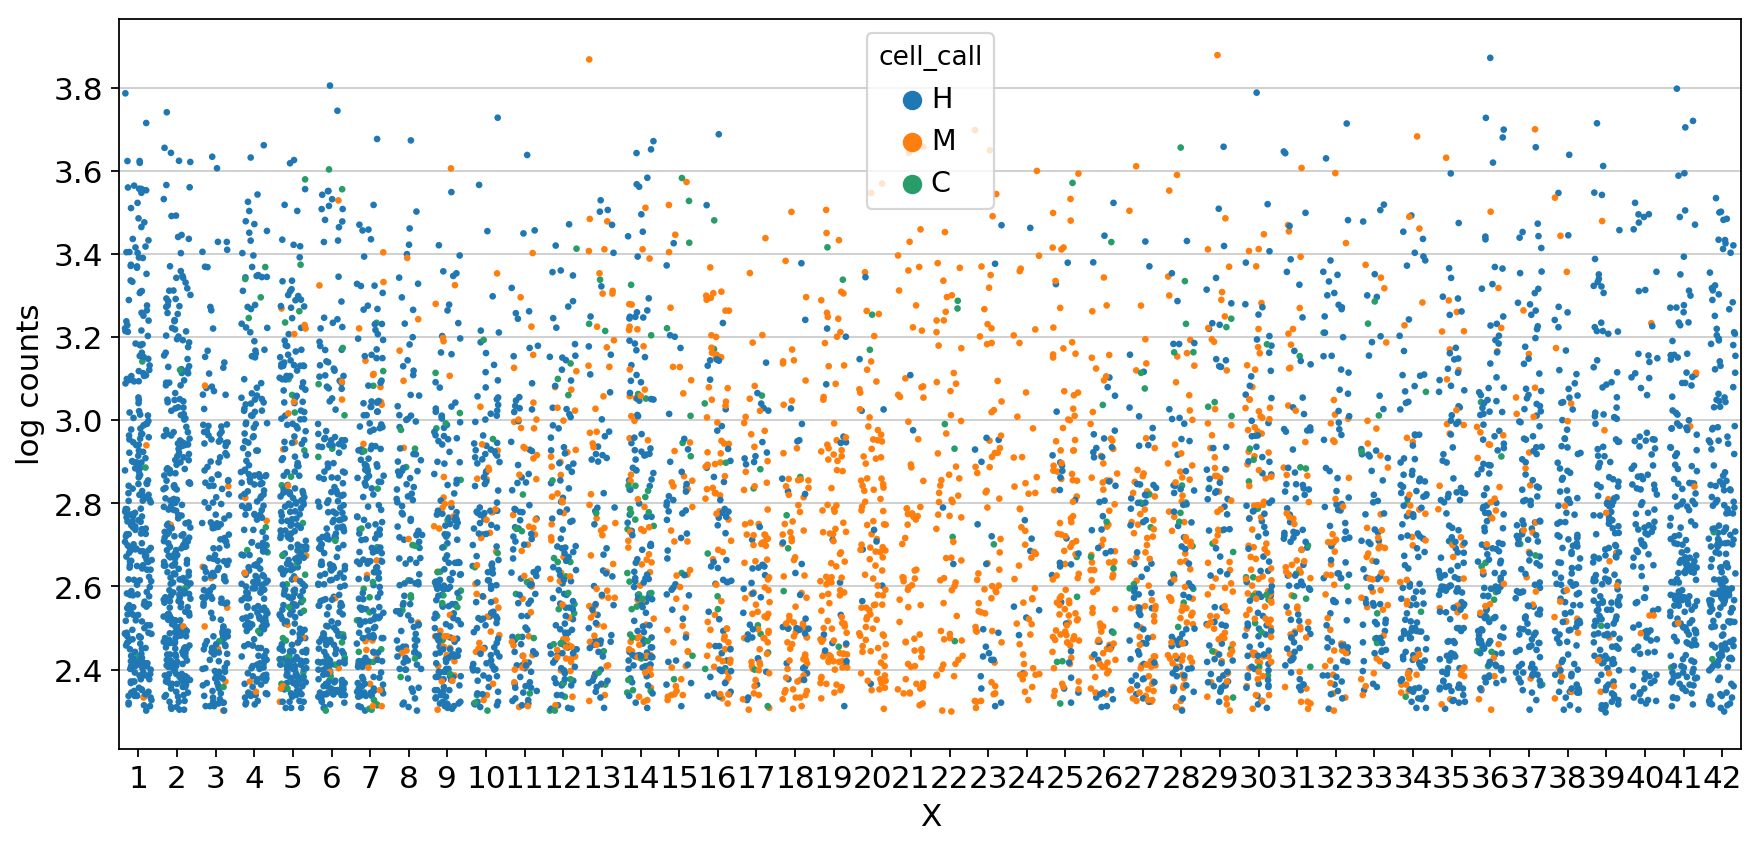

In [37]:
temp=sns.stripplot(x='X', 
              y='log counts', 
              data=df, 
              hue='cell_call',
        
              jitter=0.35,
              size=3)


# plt.axis('off')
# plt.grid(False) 


In [38]:
df['X']=rand_jitter(df['X'])
df['Y']=rand_jitter(df['Y'])


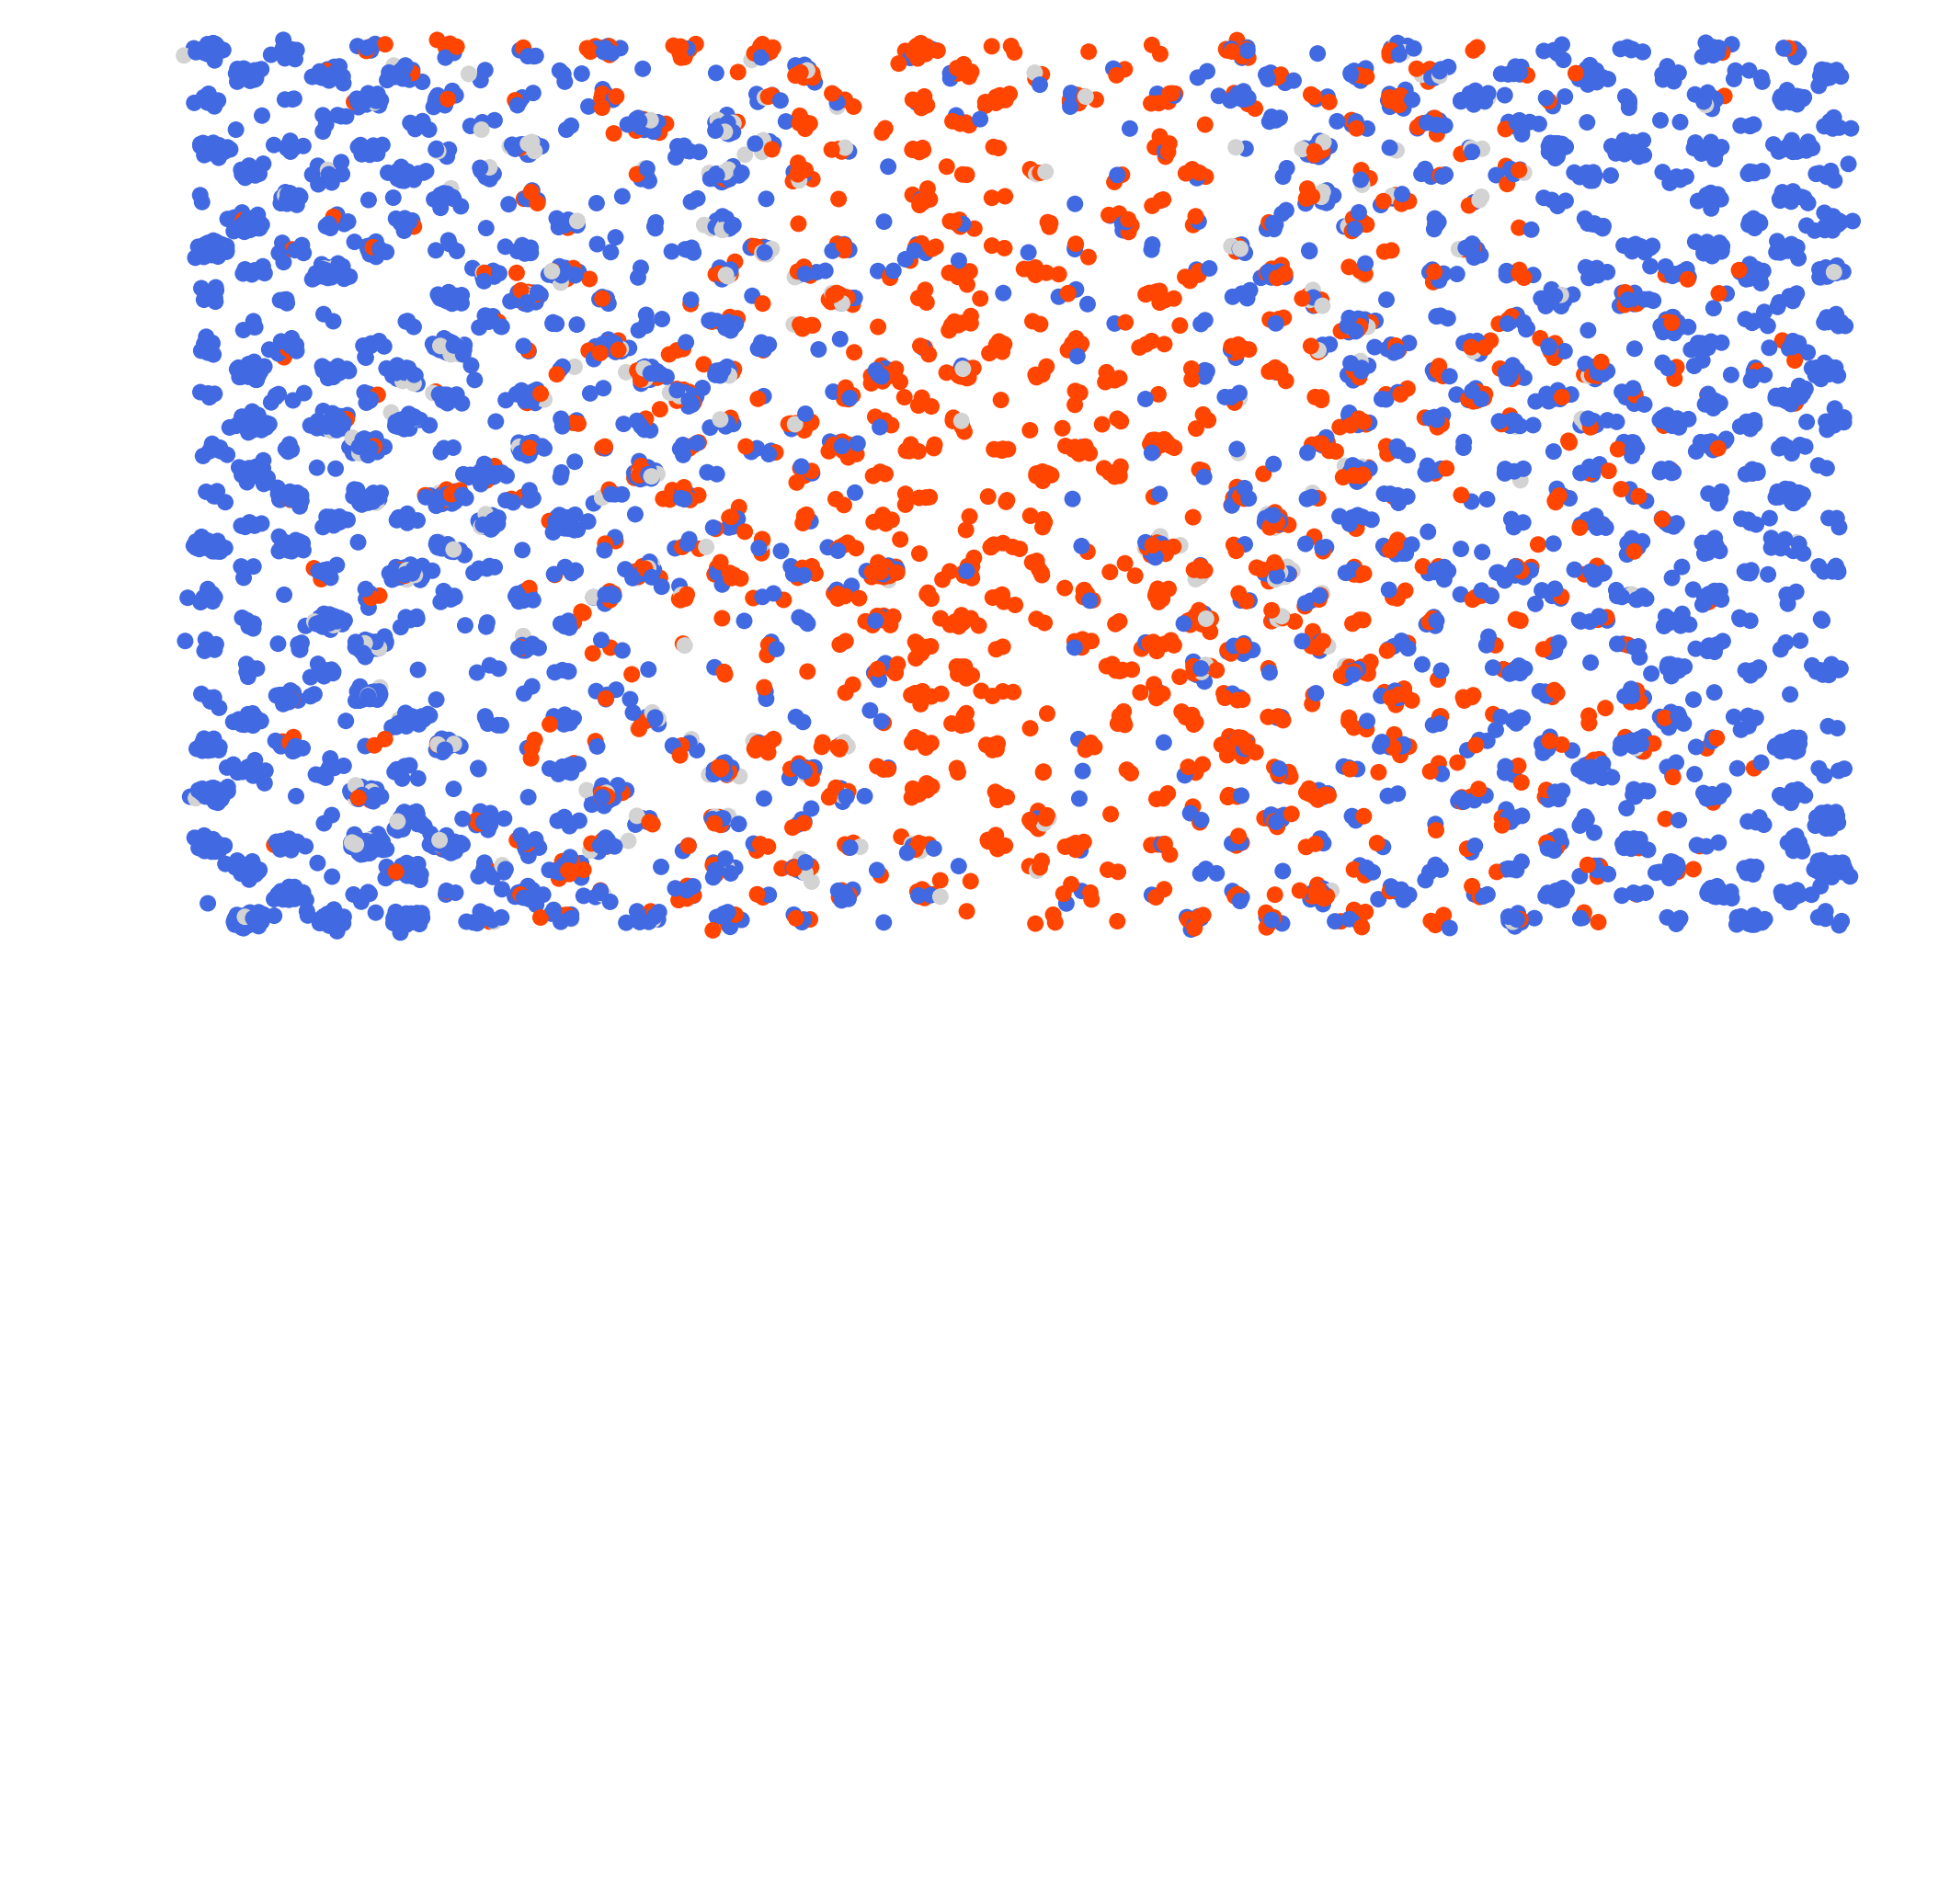

In [39]:
plt.rcParams['figure.figsize'] = [16, 16]

df.plot.scatter(x='X',y='Y',c=df['color'], s=50)
plt.ylim(18,0)

plt.axis('off')
plt.grid(False)